In [1]:
import cv2
import numpy as np
import os
from os import path as osp
from glob import glob
import matplotlib.pyplot as plt

from superpoint.settings import EXPER_PATH
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_paths(exper_name):
    return glob(osp.join(EXPER_PATH, 'outputs/{}/*.npz'.format(exper_name)))

In [3]:
def compute_tp_fp(data, remove_zero=1e-4, distance_thresh=2, simplified=False):
    # Read data
    gt = np.where(data['keypoint_map'])
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    prob = data['prob']

    # Filter out predictions with near-zero probability
    mask = np.where(prob > remove_zero)
    prob = prob[mask]
    pred = np.array(mask).T
    
    # When several detections match the same ground truth point, only pick
    # the one with the highest score  (the others are false positive)
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]

    # Compute 
    diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, distance_thresh)
    
    tp = []
    matched = np.zeros(len(gt))
    for m in matches:
        correct = np.any(m)
        if correct:
            gt_idx = np.argmax(m)
            tp.append(not matched[gt_idx])
            matched[gt_idx] = 1
        else:
            tp.append(False)
    tp = np.array(tp, bool)
    if simplified:
        tp = np.any(matches, axis=1)  # keeps multiple matches for the same gt point
        n_gt = np.sum(np.minimum(np.sum(matches, axis=0), 1)) # buggy
    fp = np.logical_not(tp)
    return tp, fp, prob, n_gt

In [4]:
def div0( a, b ):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        idx = ~np.isfinite(c)
        c[idx] = np.where(a[idx] == 0, 1, 0)  # -inf inf NaN
    return c

In [5]:
def compute_pr(exper_name, **kwargs):
    # Gather TP and FP for all files
    paths = get_paths(exper_name)
    tp, fp, prob, n_gt = [], [], [], 0
    for path in paths:
        t, f, p, n = compute_tp_fp(np.load(path), **kwargs)
        tp.append(t)
        fp.append(f)
        prob.append(p)
        n_gt += n
    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)

    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    # Cumulative
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = div0(tp_cum, n_gt)
    precision = div0(tp_cum, tp_cum + fp_cum)
    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]
    return precision, recall, prob

In [6]:
def compute_mAP(precision, recall):
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))

In [7]:
def compute_loc_error(exper_name, prob_thresh=0.5, distance_thresh=2):
    def loc_error_per_image(data):
        # Read data
        gt = np.where(data['keypoint_map'])
        gt = np.stack([gt[0], gt[1]], axis=-1)
        prob = data['prob']

        # Filter out predictions
        mask = np.where(prob > prob_thresh)
        pred = np.array(mask).T
        prob = prob[mask]

        if not len(gt) or not len(pred):
            return []

        diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
        dist = np.linalg.norm(diff, axis=-1) 
        dist = np.min(dist, axis=1)
        correct_dist = dist[np.less_equal(dist, distance_thresh)]
        return correct_dist
    paths = get_paths(exper_name)
    error = []
    for path in paths:
        error.append(loc_error_per_image(np.load(path)))
    return np.mean(np.concatenate(error))

# Experiments

In [17]:
experiments = ['magic-point_synth-v2', 'harris_synth-v2', 'shi_synth-v2', 'fast_synth-v2']
confidence_thresholds = [0.4, 90000, 0.06, 40]

# PR curve

> magic-point_synth-v2
mAP: 0.9799515726822746
Operating probability threshold 1: 0.4385473430156708
Operating probability threshold 2: 0.48284754157066345
> harris_synth-v2
mAP: 0.10281380968922635
Operating probability threshold 1: 89391.203125
Operating probability threshold 2: 125241536.0
> shi_synth-v2
mAP: 0.3517684102750394
Operating probability threshold 1: 0.06009399890899658
Operating probability threshold 2: 0.9900010228157043
> fast_synth-v2
mAP: 0.602107642918117
Operating probability threshold 1: 42.0
Operating probability threshold 2: 201.0


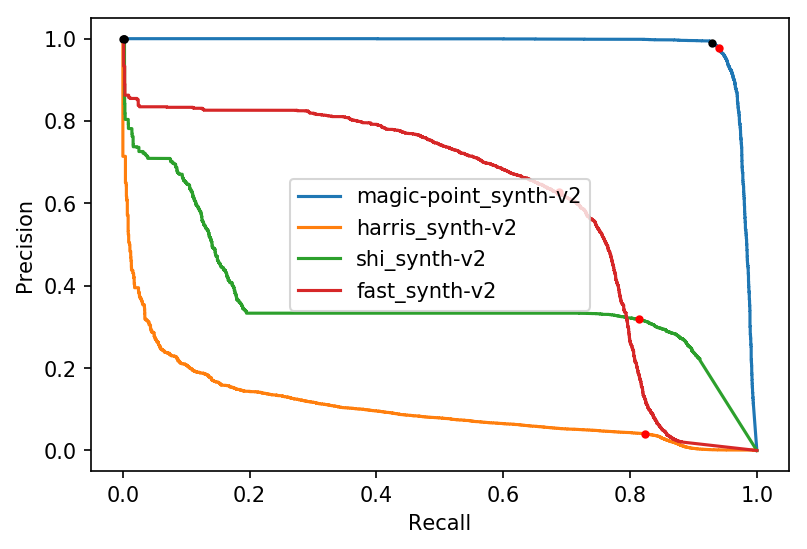

In [16]:
plt.figure(dpi=150)
for e in experiments:
    p, r, prob =  compute_pr(e, distance_thresh=4)
    plt.plot(r, p, label=e);
    
    mAP = compute_mAP(p, r)
    op_idx1 = np.argmin(np.linalg.norm([1-p, 1-r], axis=0))
    op_idx2 = np.max(np.where(p > 0.99))
    print('> {}'.format(e))
    print('mAP: {}'.format(mAP))
    print('Operating probability threshold 1: {}'.format(prob[op_idx1]))
    print('Operating probability threshold 2: {}'.format(prob[op_idx2]))
    plt.plot(r[op_idx1], p[op_idx1], marker='o', color='r', markersize=3)
    plt.plot(r[op_idx2], p[op_idx2], marker='o', color='k', markersize=3)
plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');

# Localization Error

In [19]:
for e, t in zip(experiments, confidence_thresholds):
    error = compute_loc_error(e, prob_thresh=t, distance_thresh=4)
    print('> {}: {}'.format(e, error))

> magic-point_synth-v2: 0.17734734059836418
> harris_synth-v2: 2.1064109355082676
> shi_synth-v2: 1.6652815295339414
> fast_synth-v2: 2.02653952735985


# Visualization

In [20]:
def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(corners).T]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

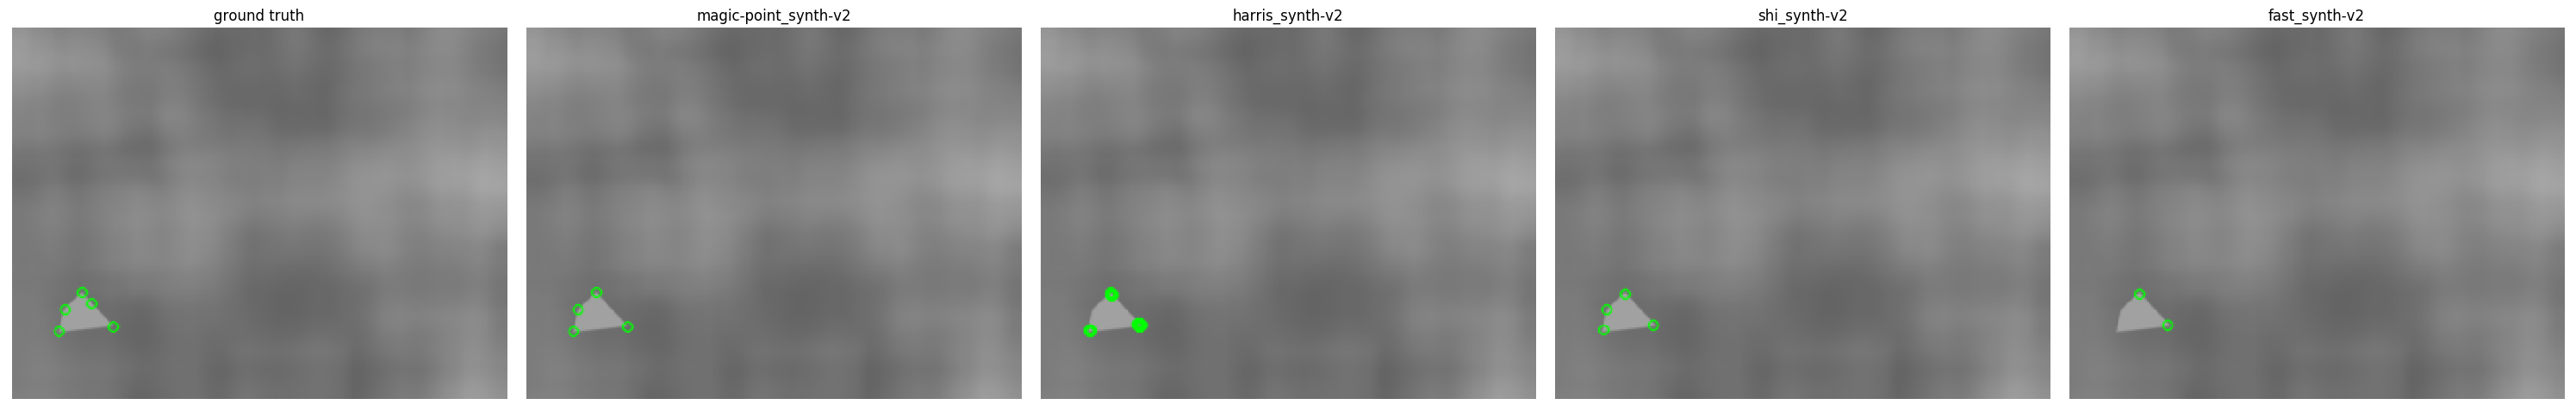

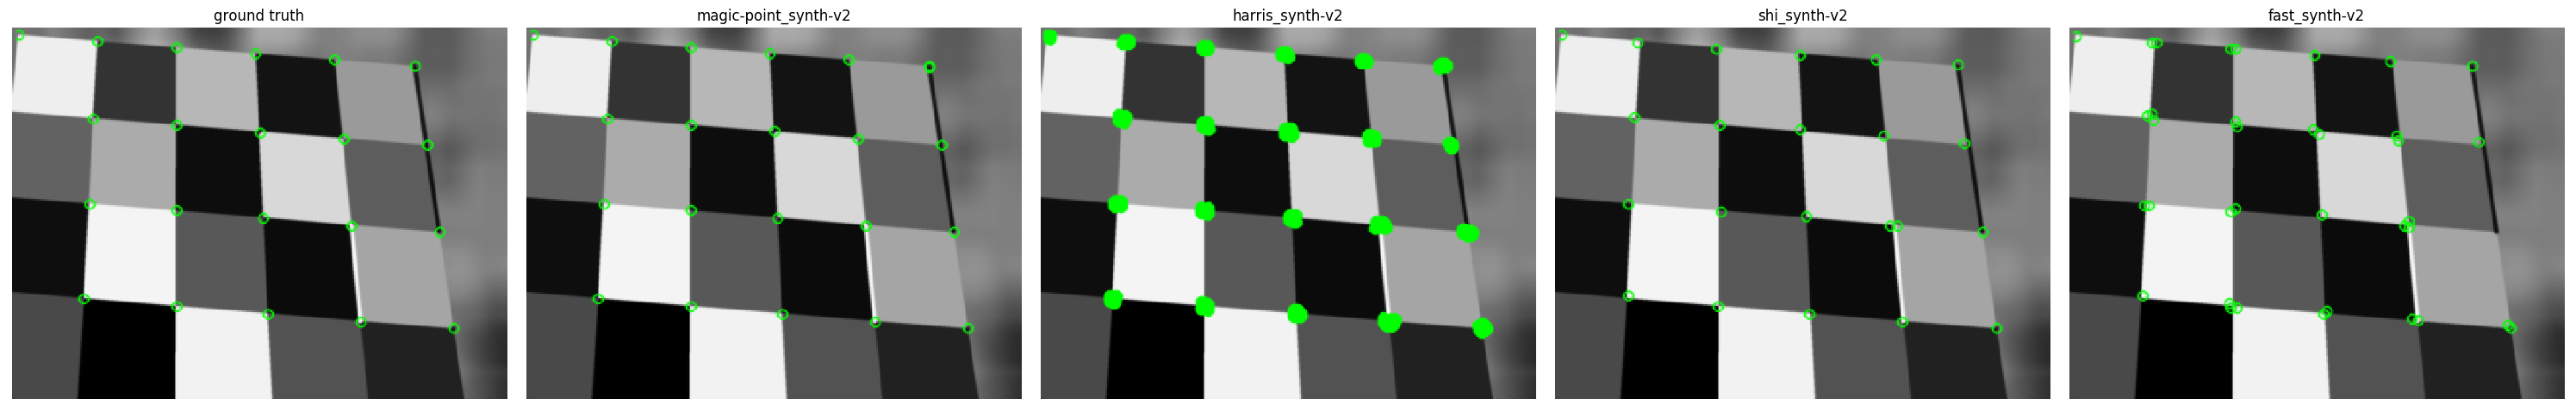

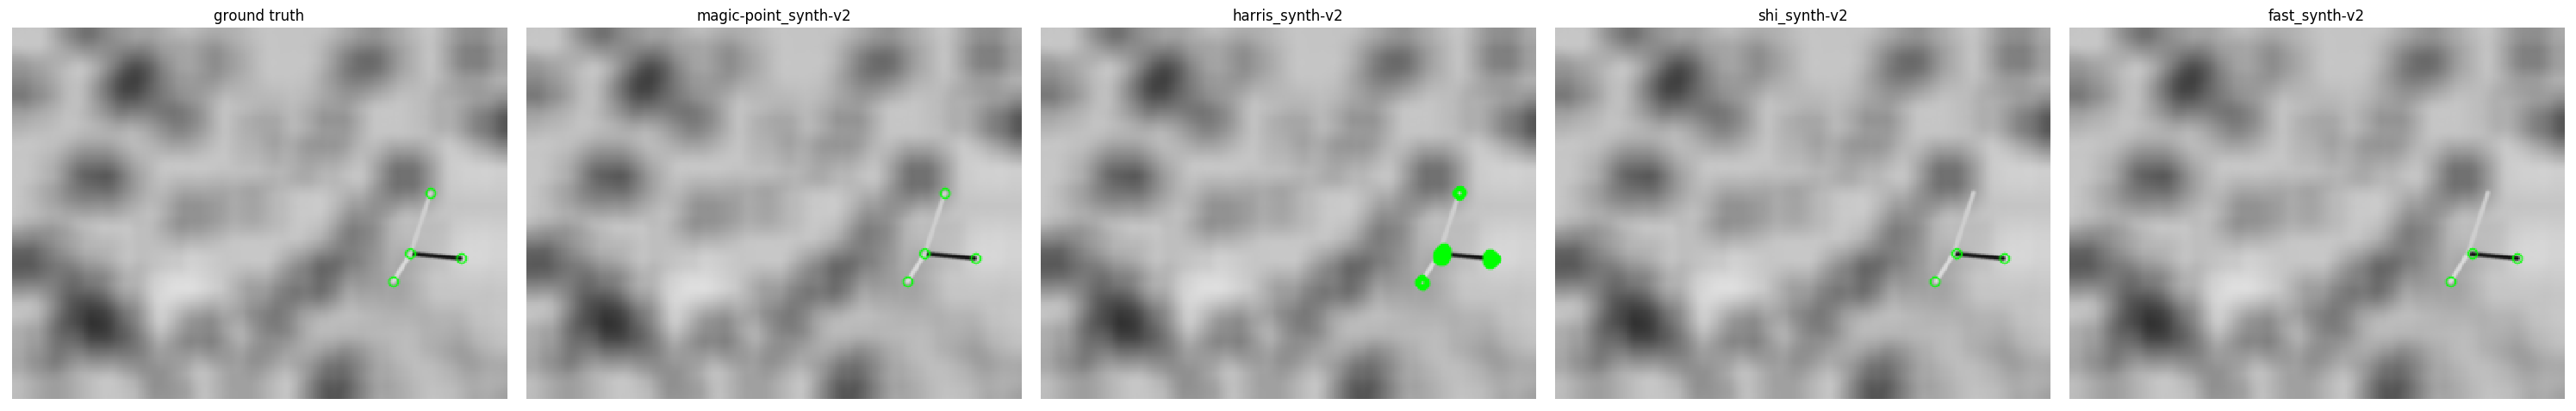

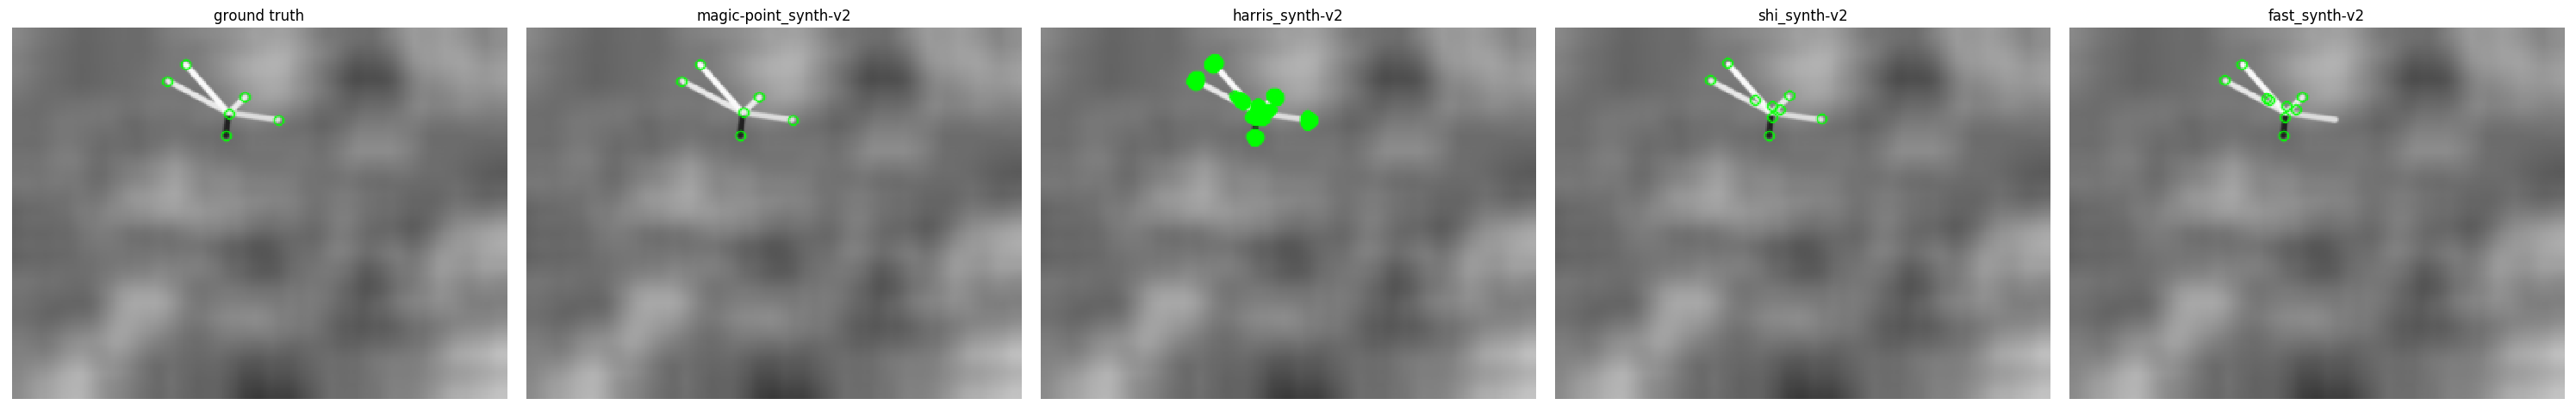

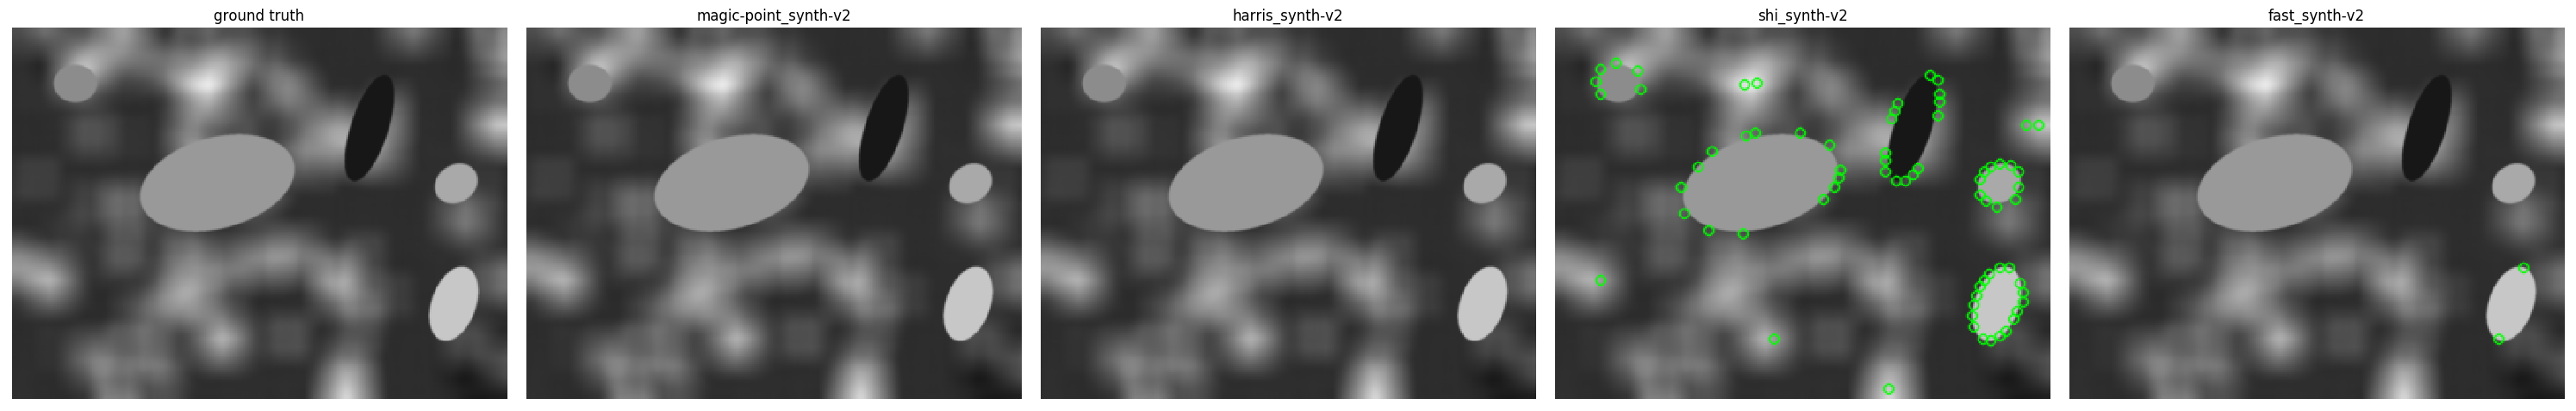

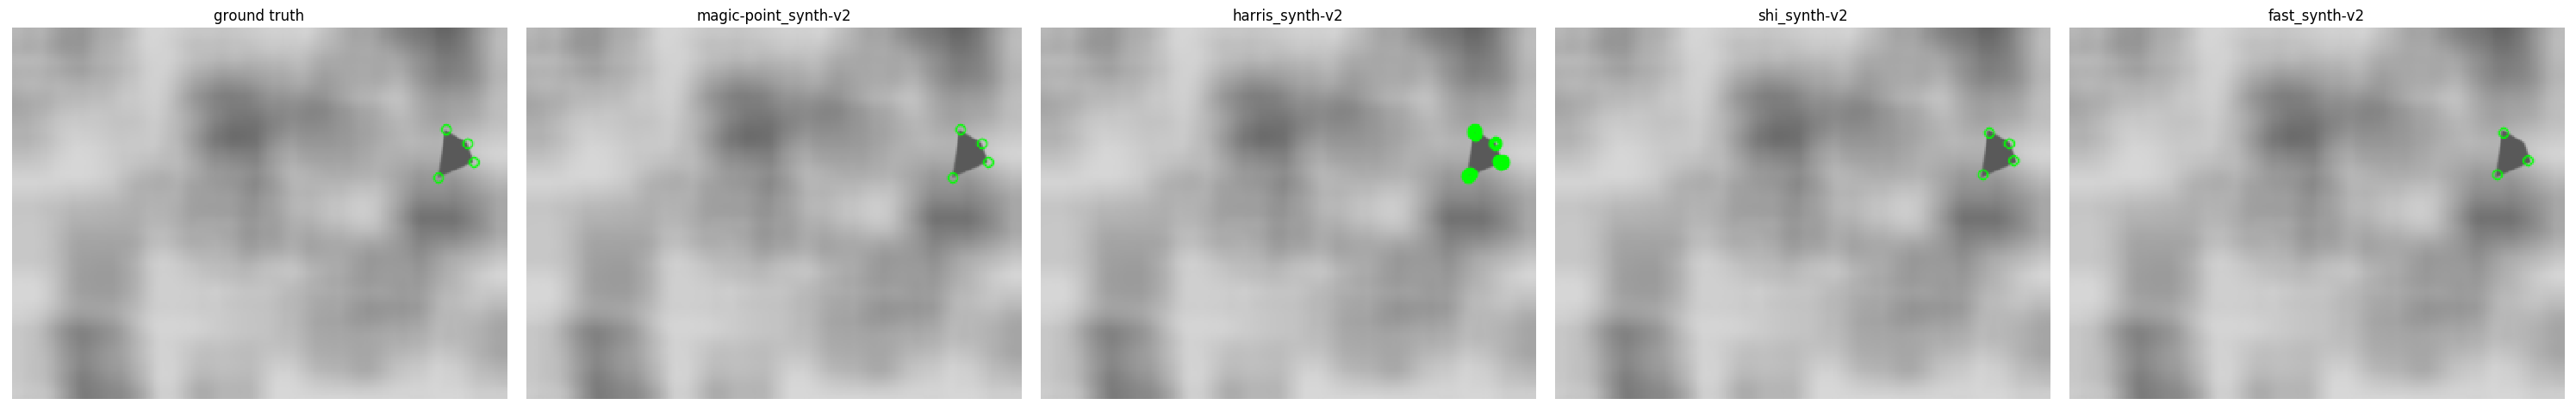

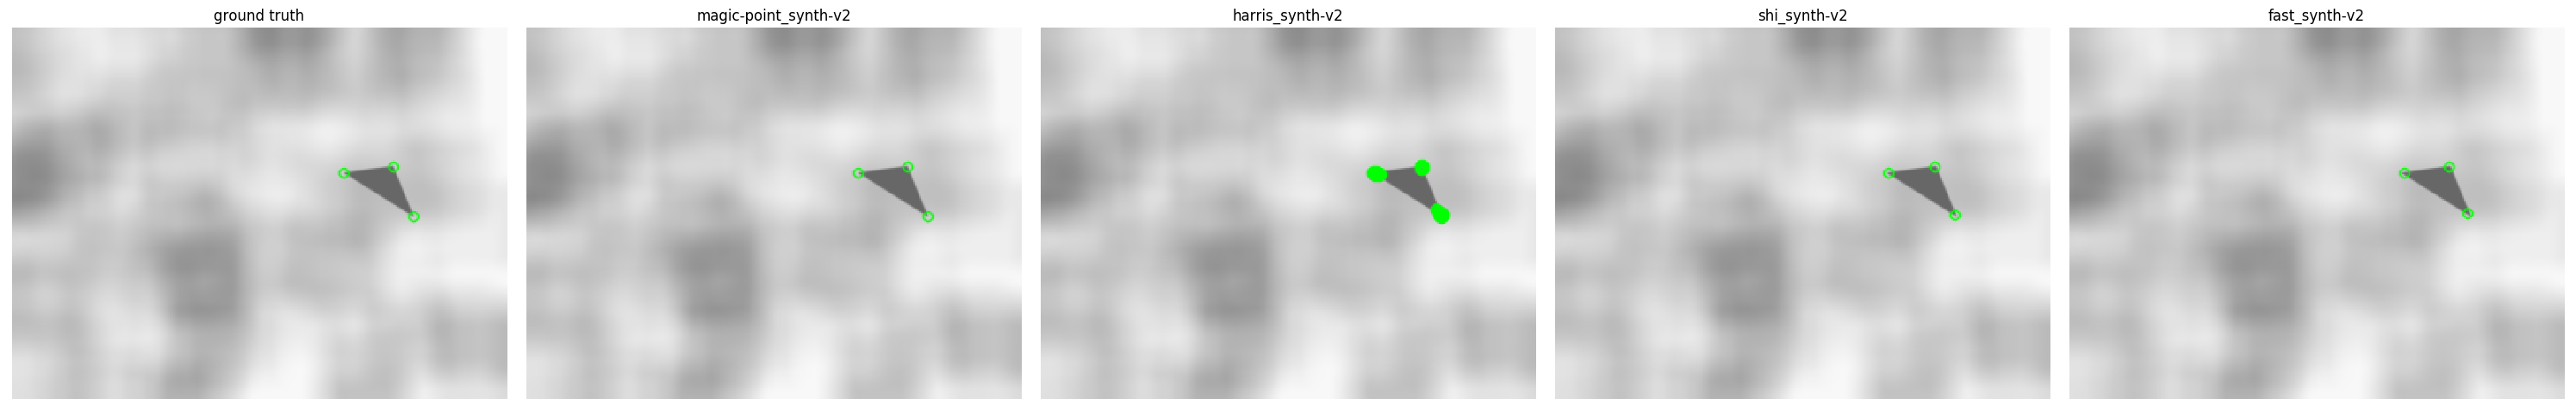

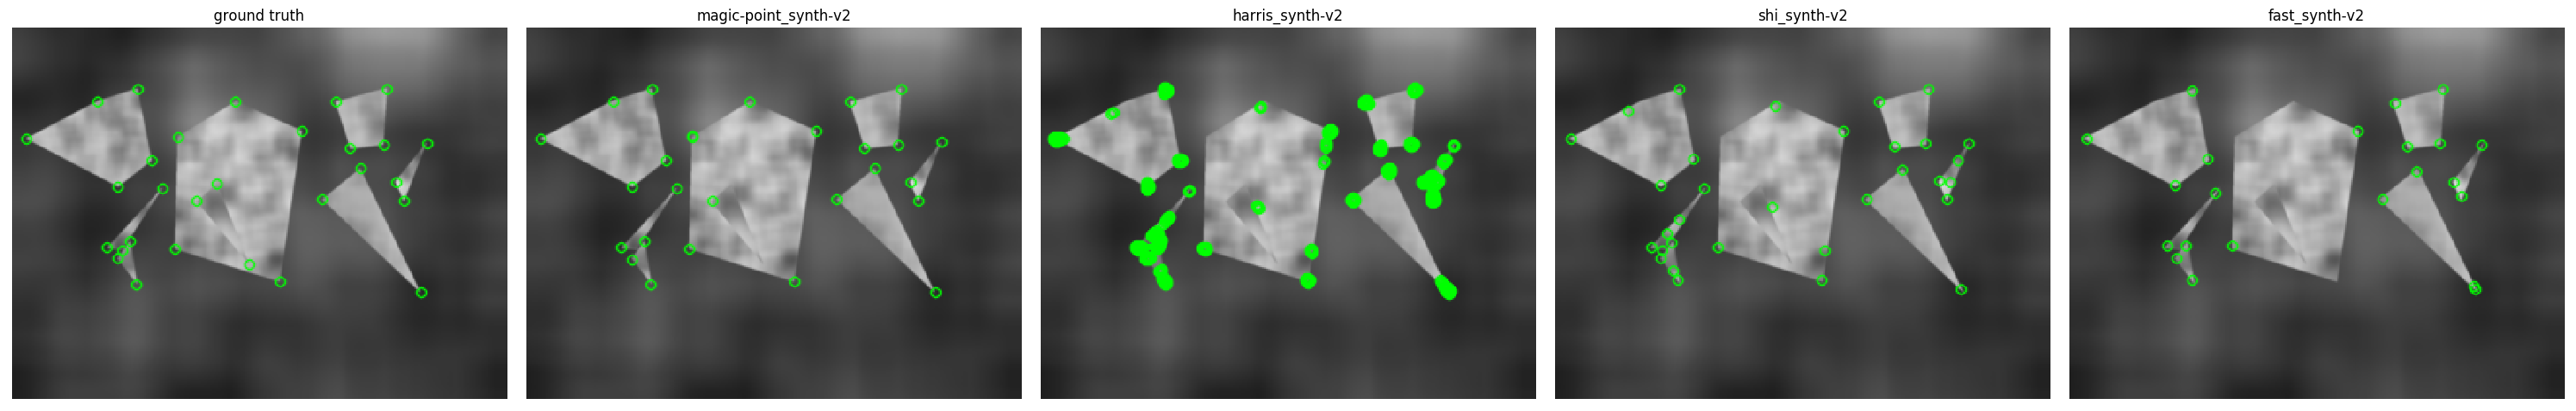

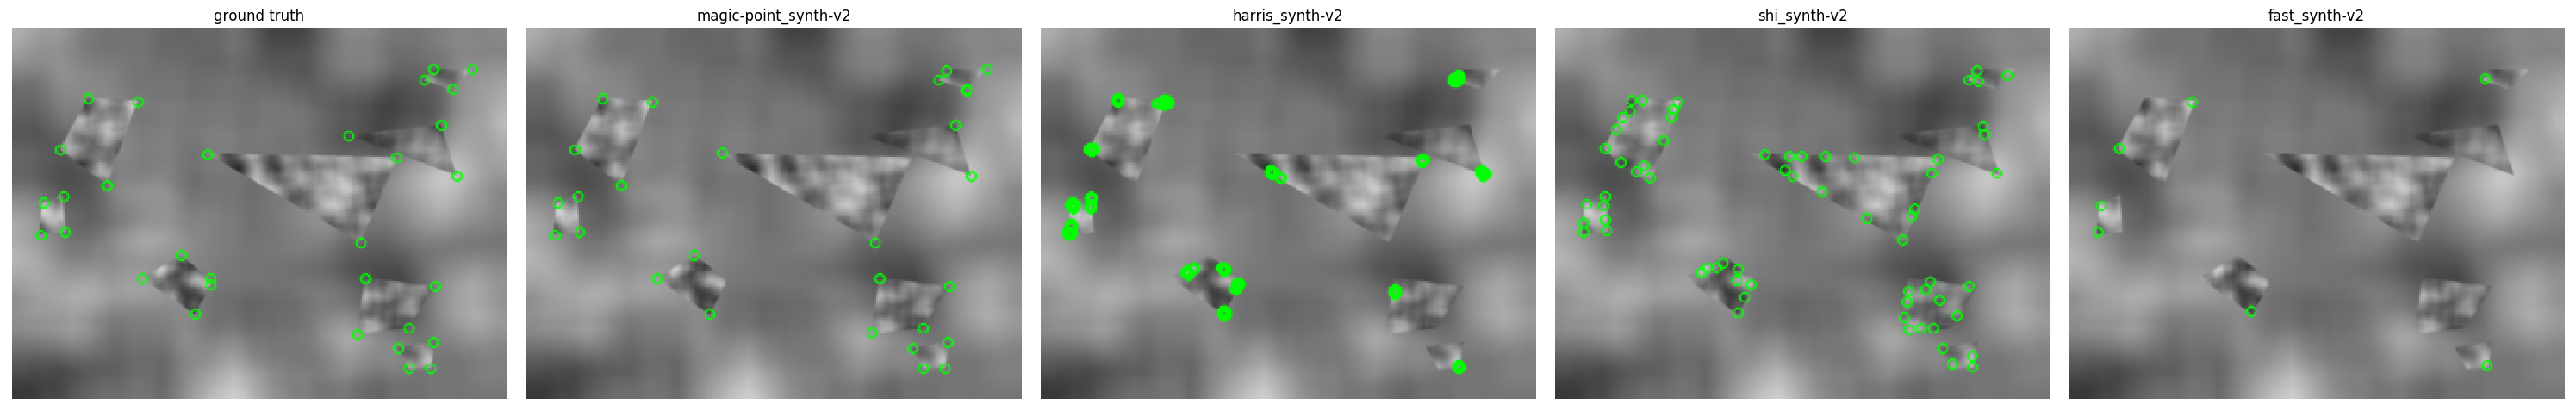

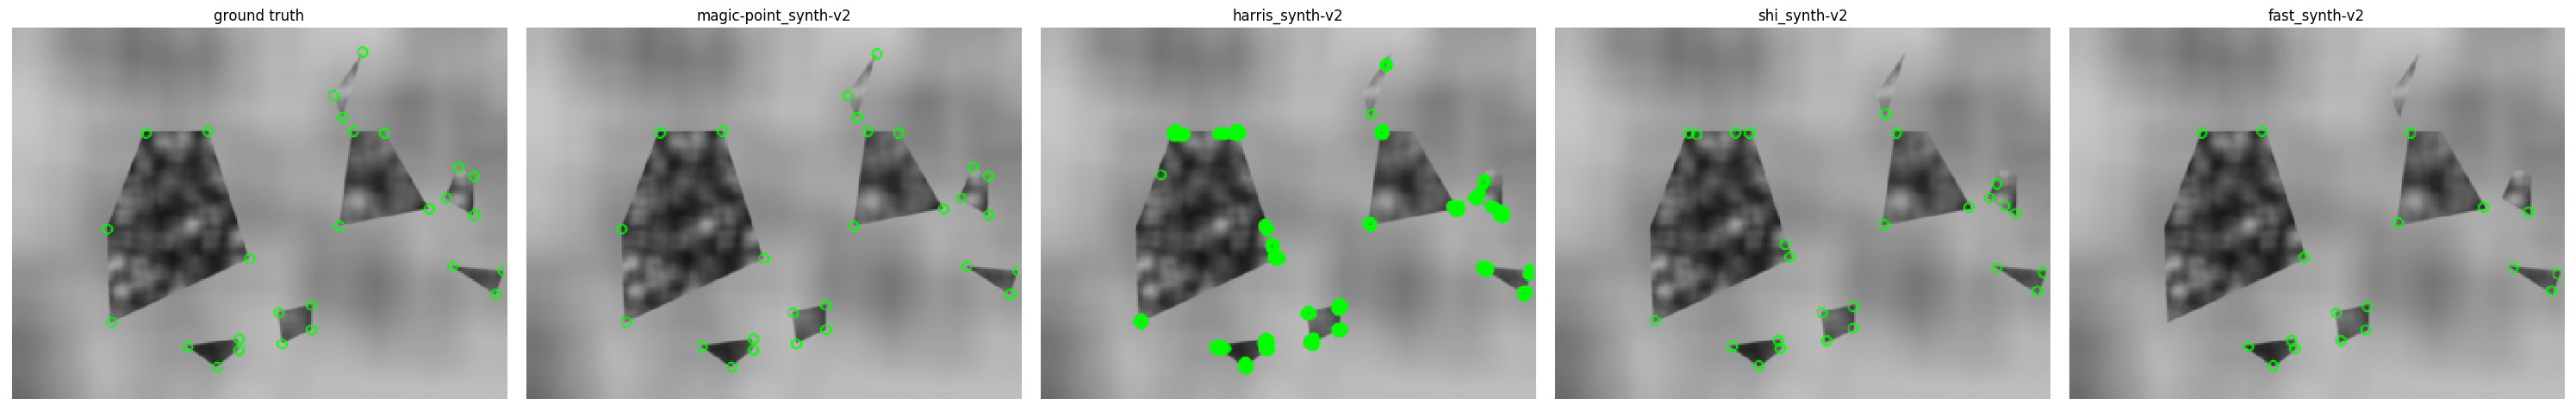

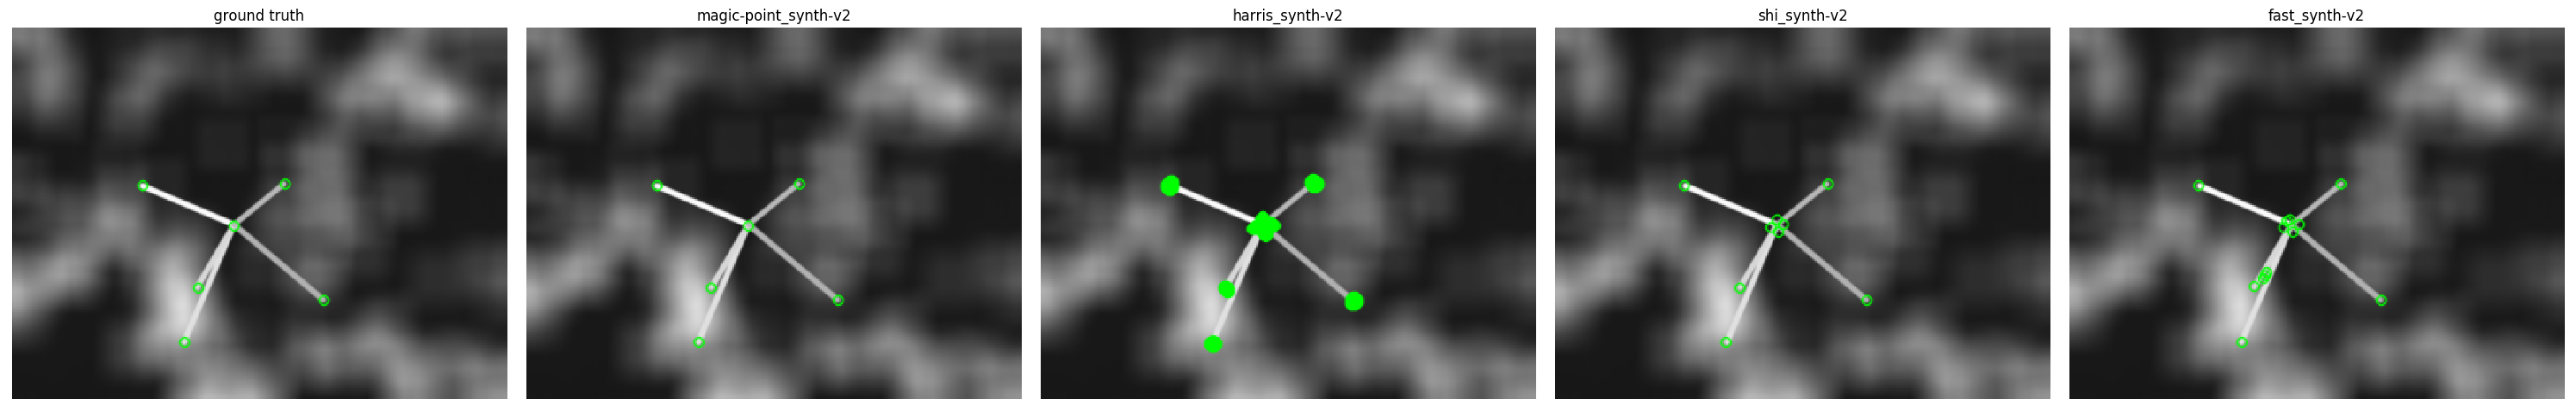

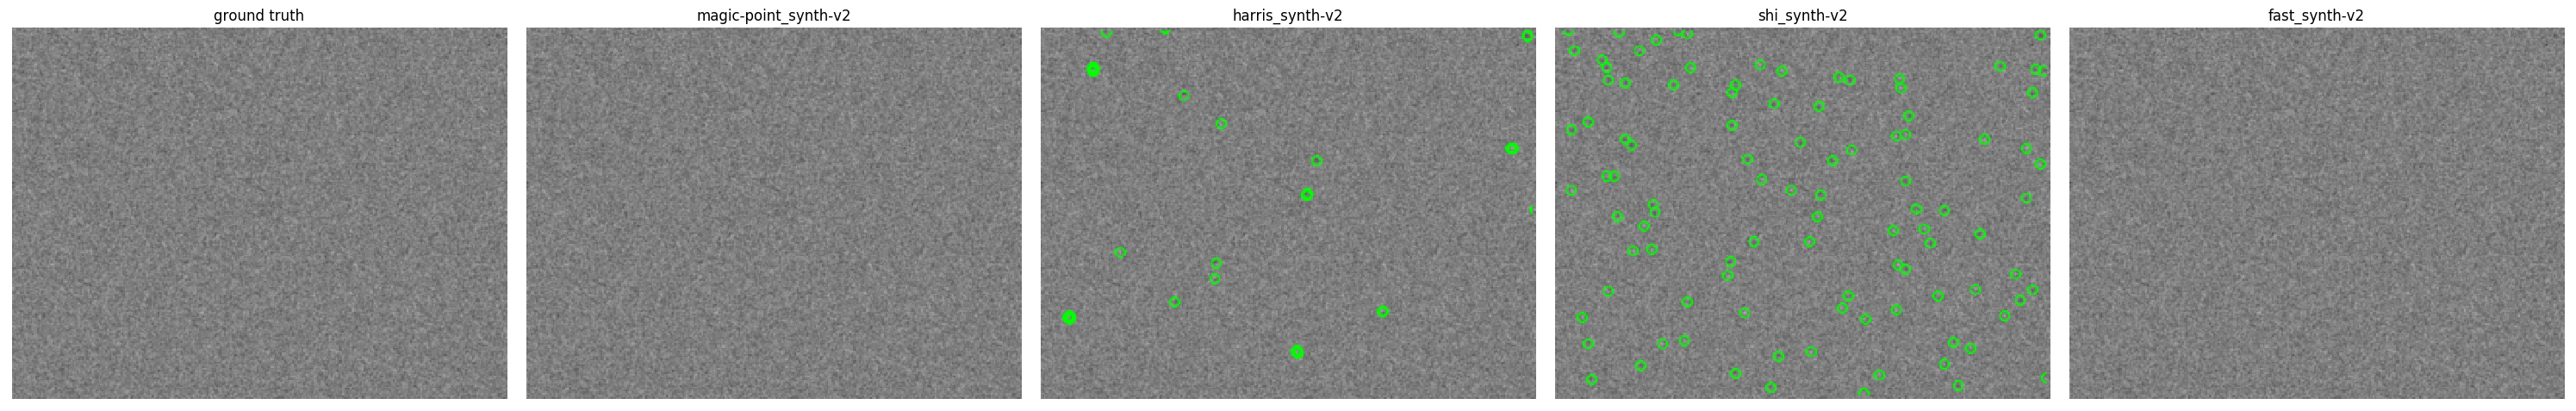

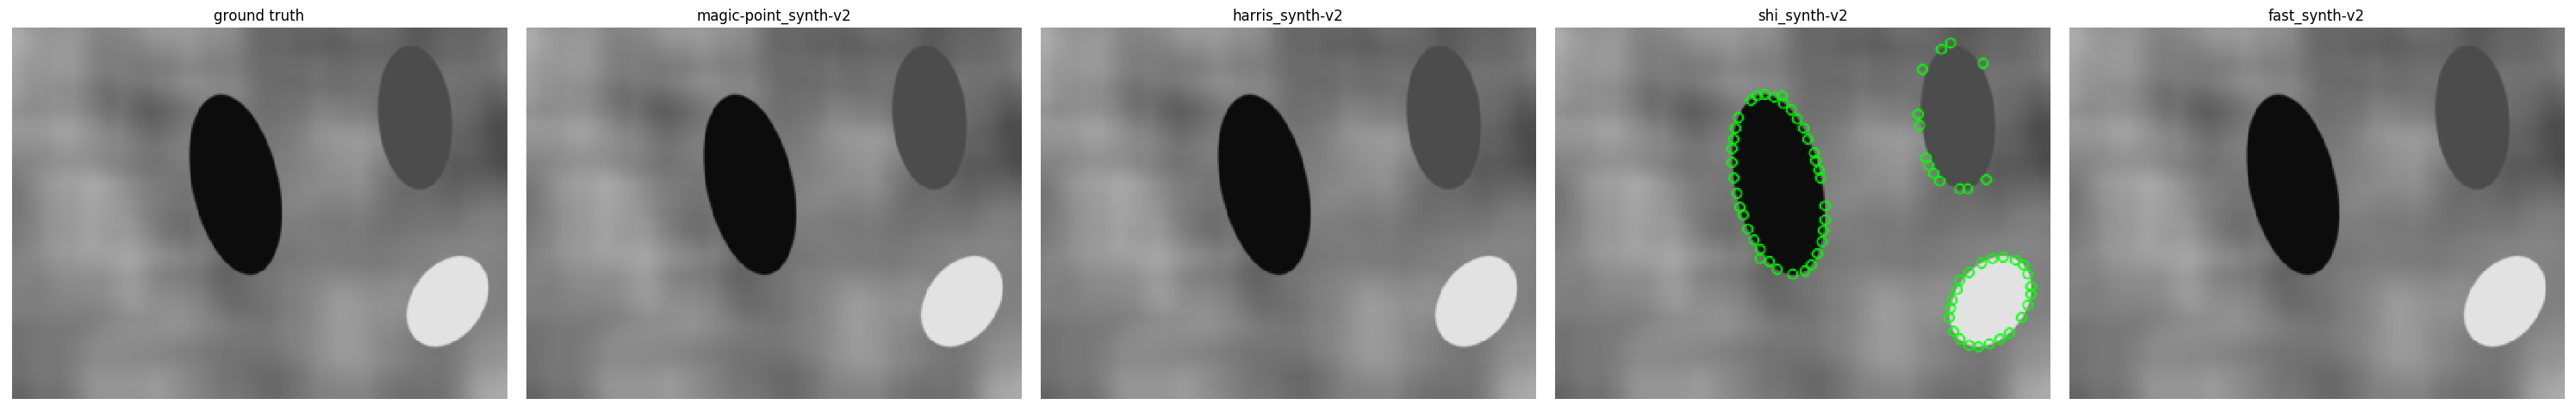

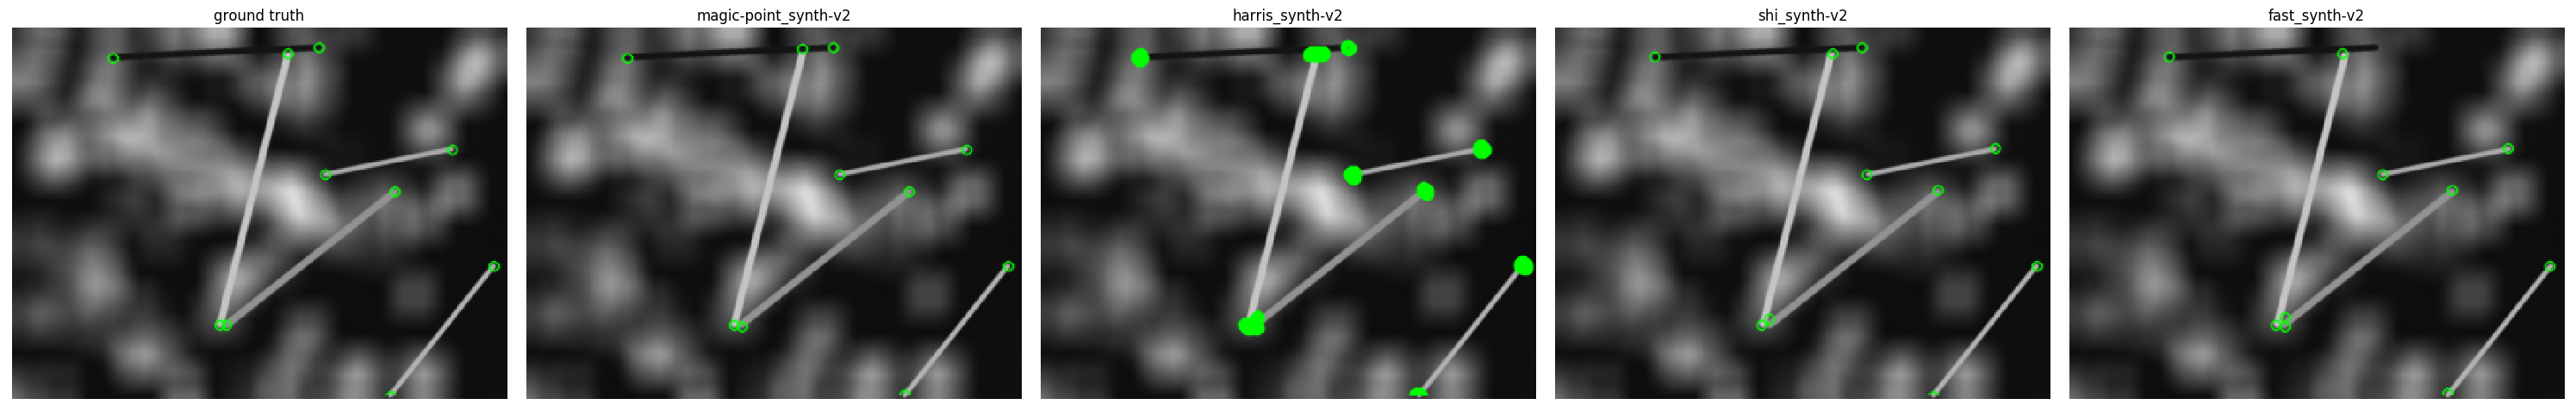

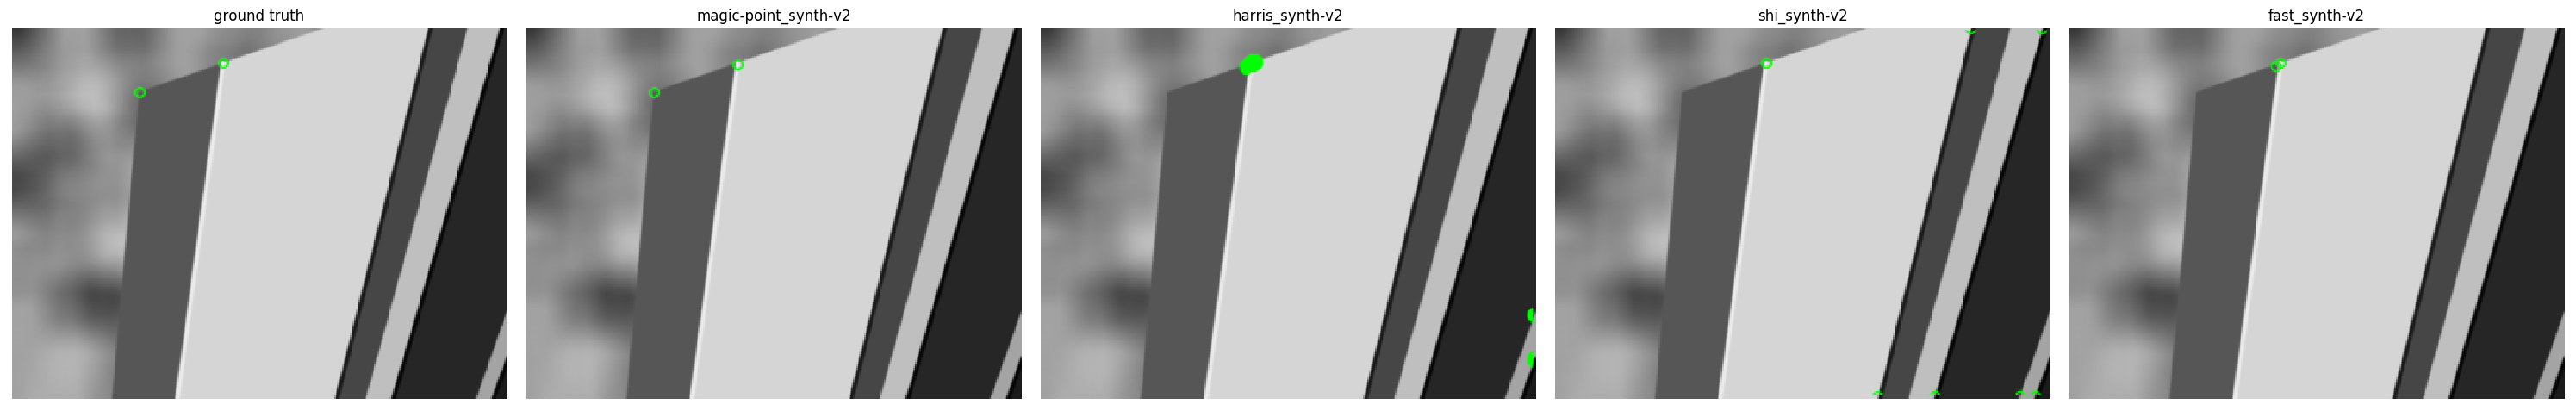

In [21]:
paths = [get_paths(e) for e in experiments]
for i in range(15):
    images = []
    for j, (e, t) in enumerate(zip(experiments, confidence_thresholds)):
        data = np.load(paths[j][i])
        if e == experiments[0]:
            images.append(draw_keypoints(data['image'], np.where(data['keypoint_map']), (0, 255, 0)))
        images.append(draw_keypoints(data['image'], np.where(data['prob'] > t), (0, 255, 0)))
    plot_imgs([im/255. for im in images], titles=['ground truth']+experiments)